# Analysis on Text-to-Clip_Retrieval results

Multilevel Language and Vision Integration for Text-to-Clip Retrieval

In [8]:
cd /mnt/sda/otani/Experiments/moment_retrieval/

/mnt/sda/otani/Experiments/moment_retrieval


In [9]:
import pandas as pd
import numpy as np
# from gensim.corpora import Dictionary
# from gensim.parsing.preprocessing import preprocess_string
# from gensim.parsing.preprocessing import strip_punctuation, stem_text, strip_multiple_whitespaces, remove_stopwords
import json
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load("en_core_web_sm")

In [15]:
train_df = pd.read_csv('data/processed/train.csv')
test_df = pd.read_csv('data/processed/test.csv')

In [99]:
# def preprocess_desc(desc):
#     CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation, strip_multiple_whitespaces, remove_stopwords, stem_text]
#     desc = [preprocess_string(s, CUSTOM_FILTERS) for s in desc]
#     return desc

def preprocess_desc(desc):
    processed_desc = []
    for d in desc:
        tokens = nlp(d)
        filtered_token = []
        for token in tokens:
            if token.text == "person":
                continue
            if token.is_stop:
                continue
            if token.is_alpha:
                filtered_token.append(token.lemma_)
        processed_desc.append(filtered_token)
    return processed_desc

def get_action(desc):
    actions = []
    for d in desc:
        tokens = nlp(d)
        for token in tokens:
            if token.is_stop:
                continue
            if token.tag_[:2] == 'VB':
                actions.append(token.lemma_)
    return actions

def build_dict(descriptions):
    desc = preprocess_desc(descriptions)
    dictionary = Dictionary(desc)
    dictionary.compactify()
    return dictionary


# dictionary = build_dict(train_df['description'])

In [60]:
train_desc = preprocess_desc(train_df['description'])
test_desc = preprocess_desc(test_df['description'])
# train_desc_ids = [np.asarray(dictionary.doc2idx(x)) for x in train_desc]
# test_desc_ids = [np.asarray(dictionary.doc2idx(x)) for x in test_desc]

In [64]:
seen_count = 0
unseen_test = []
for i, d in enumerate(test_desc):
    is_seen = False
    for t in train_desc:
        if d == t:
            seen_count += 1
            is_seen = True
            break
    if not is_seen:
        unseen_test.append(i)
        
unseen_test_df = test_df.iloc[unseen_test]

In [68]:
def _tiou(pred, gt):
    inter_left = np.maximum(pred[:,0], gt[0])
    inter_right = np.minimum(pred[:,1], gt[1])
    inter = np.maximum(0.0, inter_right - inter_left)
    union_left = np.minimum(pred[:,0], gt[0])
    union_right = np.maximum(pred[:,1], gt[1])
    union = np.maximum(0.0, union_right - union_left)
    return 1.0 * inter / union

def _nms(dets, scores, thresh=0.4):
    """Pure Python NMS baseline."""
    if len(dets) == 0: return []
    x1 = dets[:, 0]
    x2 = dets[:, 1]
    scores = scores
    lengths = x2 - x1
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        inter = np.maximum(0.0, xx2 - xx1)
        ovr = inter / (lengths[i] + lengths[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]
    return keep

def computer_eval(preds, gts, iou_thresh=0.5, nms_thresh=0.1, recall=[1]):
    results = {}
    for key, val in preds.items():
        queries = val[0]['query']
        gt_key = key
        gt = gts[gt_key]
        proposals = np.empty((0,2))
        scores = np.empty((queries.shape[0], 0))

        for item in val:
            proposals = np.vstack((proposals, item['timestamp'][:,:2]))
            scores = np.hstack((scores, item['sim_scores']))

        recall_queries = []
        for i,q in enumerate(queries):
            keep = _nms(proposals, scores[i], thresh=nms_thresh-0.05)[:max(recall)]
            gt_win = gt['timestamps'][i]
            pred_win = proposals[keep]
            overlap = _tiou(pred_win, gt_win)
            recall_queries.append([(overlap > iou_thresh)[:d].any() for d in recall])
        results[gt_key] = recall_queries
        
    return results

In [69]:
preds = pickle.load(open('data/external/sim_iter_5000.p', 'rb'), encoding='latin1')
gts = json.load(open('data/external/caption_gt_test.json'))
recall_at = [1, 5, 10]
results = computer_eval(preds, gts, 0.5, recall_at)

# Q1: Does the model generalize to unseen queries?

In [70]:
unseen_results = {}
seen_results = {}

for key, val in preds.items():
    val[0]['sentences'] = gts[key]['sentences']

for key, val in preds.items():
    queries = val[0]['sentences']
    unseen_idx = []
    seen_idx = []
    for i, q in enumerate(queries):
        res = unseen_test_df[(unseen_test_df.id == key) & (unseen_test_df.description == q)]
        if len(res):
            unseen_idx.append(i)
        else:
            seen_idx.append(i)
    
    unseen_results[key] = [results[key][i] for i in unseen_idx]
    seen_results[key] = [results[key][i] for i in seen_idx]

In [71]:
print('Unseen queries')
eval_res = []
for k, v in unseen_results.items():
    eval_res += v
eval_res = np.array(eval_res).mean(axis=0)

for i in range(len(recall_at)):
    print(f"r@{recall_at[i]}: {eval_res[i]:.2f}")
    
print('Seen queries')
eval_res = []
for k, v in seen_results.items():
    eval_res += v
eval_res = np.array(eval_res).mean(axis=0)

for i in range(len(recall_at)):
    print(f"r@{recall_at[i]}: {eval_res[i]:.2f}")

Unseen queries
r@1: 0.31
r@5: 0.73
r@10: 0.89
Seen queries
r@1: 0.34
r@5: 0.76
r@10: 0.90


## Conclusion: The model still achieves comparable performance to seen queries

# Q2: What differences are there between success and failure samples?

In [51]:
correct = {}
incorrect = {}
failures = []
for k, res in results.items():
    for i, v in enumerate(res):
        if v.any():
            continue
            
        query = gts[k]['sentences'][i]
        gt_timestamp = gts[k]['timestamps'][i]
        failures.append({'video': k, 'query': query, 'timestamp':gt_timestamp})

In [46]:
def get_results(preds, gts, thresh=0.1, recall=[1]):
    results = {}
    for key, val in preds.items():
        queries = val[0]['query']
        gt_key = key
        gt = gts[gt_key]
        proposals = np.empty((0,2))
        scores = np.empty((queries.shape[0], 0))

        for item in val:
            proposals = np.vstack((proposals, item['timestamp'][:,:2]))
            scores = np.hstack((scores, item['sim_scores']))

        recall_queries = []
        pred_wins = []
        for i,q in enumerate(queries):
            keep = _nms(proposals, scores[i], thresh=thresh-0.05)[:max(recall)]
            gt_win = gt['timestamps'][i]
            pred_win = proposals[keep]
            overlap = _tiou(pred_win, gt_win)
            recall_queries.append([(overlap > thresh)[:d].any() for d in recall])
            pred_wins.append(pred_win[:max(recall)])
            
        results[gt_key] = {
            'result': recall_queries,
            'sentences': gt['sentences'],
            'timestamp': gt['timestamps'],
            'pred': pred_wins
        }
        
    return results

In [47]:
pred_results = get_results(preds, gts, 0.5, recall_at)

In [49]:
success = {}
failure = {}
for k, v in pred_results.items():
    timestamp = v['timestamp']
    pred_win = v['pred']
    for i, q in enumerate(v['sentences']):
        item = {'query': q, 'timestamp': timestamp[i], 'pred': pred_win[i]}
        if np.any(v['result'][i]):
            # success example
            success.setdefault(k, []).append(item)
        else:
            # failure example
            failure.setdefault(k, []).append(item)

Text(0.5, 1.0, 'failure examples')

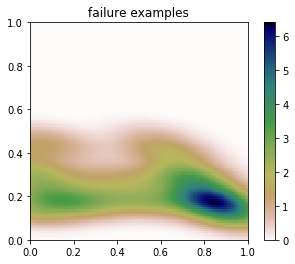

In [66]:
# Distribution of ground truth temporal windon

from scipy.stats import gaussian_kde

t_wins = []
for k, values in failure.items():
    duration = test_df[test_df.id==k].length.values[0]
    t_wins += [np.asarray(v['timestamp'])/duration for v in values]
    
t_wins = np.vstack(t_wins)
t_wins[:,-1]=t_wins[:,1]-t_wins[:,0] 
start = t_wins[:,0]
duration = t_wins[:,1]

kernel = gaussian_kde(np.vstack([start, duration]))
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title('failure examples')

Text(0.5, 1.0, 'whole samples')

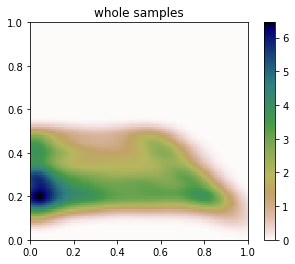

In [75]:
t_wins = []
for k, values in pred_results.items():
    duration = test_df[test_df.id==k].length.values[0]
    t_wins.append(np.asarray(values['timestamp']) / duration)
    
t_wins = np.vstack(t_wins)
t_wins[:,-1]=t_wins[:,1]-t_wins[:,0] 
start = t_wins[:,0]
duration = t_wins[:,1]

kernel = gaussian_kde(np.vstack([start, duration]))
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title('whole samples')

In [162]:
from IPython.display import Video

video_id = random.choice(list(failure.keys()))
q = failure[video_id][0]['query']
ts = failure[video_id][0]['timestamp']
pred = failure[video_id][0]['pred']

print(q)
print(ts)
print(pred[:3])
Video(f'http://localhost:8888/files/data/raw/video/{video_id}.mp4')

the person takes out their phone.
[34.0, 39.0]
[[23.1036911  32.11021805]
 [16.83517075 28.44540977]
 [27.27386284 33.9145546 ]]


# Results:

## Fails when a target moment has low prior
The model fails when ground truth moments start at a point close to the end of the video.

How can the model generalize to such samples?

- downsampling
- ???

## Many failure predictions seem to be fair
Many samples' Temporal IoU is slightly below 0.5.

R@K with IoU thresholding may be too strict

Text(0.5, 1.0, 'Maximum IoU of top 10 predictions (success)')

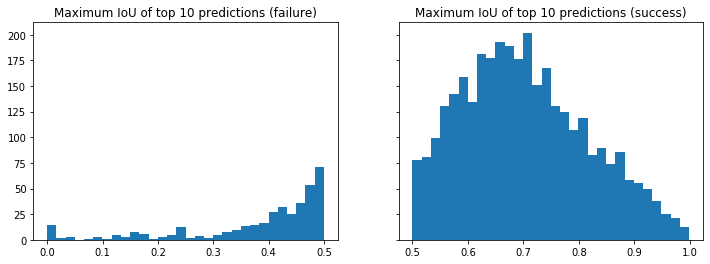

In [125]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

iou_scores = []
for k, item in failure.items():
    for x in item:
        pred = x['pred']
        ts = x['timestamp']
        iou_scores.append(_tiou(pred, ts).max())
        
axes[0].hist(iou_scores, bins=30)
axes[0].set_title('Maximum IoU of top 10 predictions (failure)')

iou_scores = []
for k, item in success.items():
    for x in item:
        pred = x['pred']
        ts = x['timestamp']
        iou_scores.append(_tiou(pred, ts).max())
        
axes[1].hist(iou_scores, bins=30)
axes[1].set_title('Maximum IoU of top 10 predictions (success)')

# Video duration?
The authro implementation truncate the video to 768 frames (5fps) == 153.6 sec.

Text(0.5, 1.0, 'Failure')

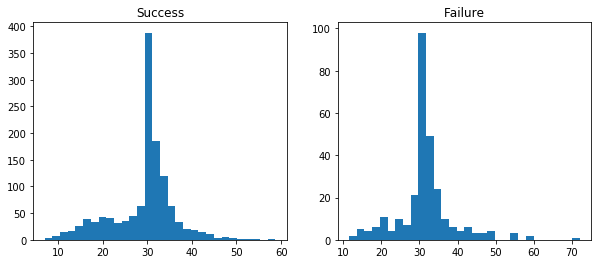

In [148]:
f, axes = plt.subplots(1, 2, figsize=(10,4))

durations = []
for video_id in success.keys():
    durations.append(test_df[test_df.id == video_id]['length'].values[0])

axes[0].hist(durations, bins=30)
axes[0].set_title('Success')

durations = []
for video_id in failure.keys():
    durations.append(test_df[test_df.id == video_id]['length'].values[0])

axes[1].hist(durations, bins=30)
axes[1].set_title('Failure')

# Caption length?

Text(0.5, 1.0, 'Failure')

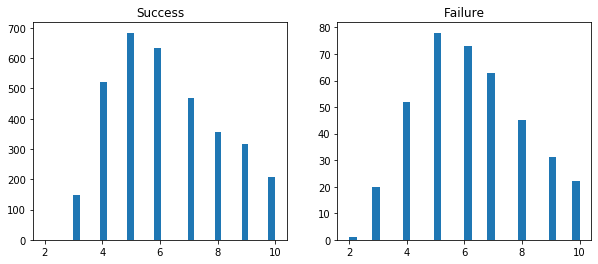

In [150]:
f, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True)

query_len = []
for _, items in success.items():
    for item in items:
        n_q = len(item['query'].split())
        query_len.append(n_q)
        
axes[0].hist(query_len, bins=30)
axes[0].set_title('Success')

query_len = []
for _, items in failure.items():
    for item in items:
        n_q = len(item['query'].split())
        query_len.append(n_q)
        
axes[1].hist(query_len, bins=30)
axes[1].set_title('Failure')

In [154]:
s_queries = []
for _, items in success.items():
    for item in items:
        q = item['query']
        s_queries.append(q)

f_queries = []
for _, items in failure.items():
    for item in items:
        q = item['query']
        f_queries.append(q)

In [155]:
s_queries[:30]

['person turn a light on.',
 'person flipped the light switch near the door.',
 'person turn the light switch on.',
 'person is playing with the switch for the light.',
 'a person sits down reading a book.',
 'a person sits at a table reading a book intensely.',
 'the person puts down the bag.',
 'person they open a cabinet.',
 'person opens the door.',
 'person opened a cabinet door.',
 'a person walks through the doorway.',
 'a person opens the door.',
 'person closes the door.',
 'person closing the door.',
 'person runs up the stairs.',
 'a person watches another run up some stairs.',
 'person puts the cup on a table.',
 'person drank from the glass,put the glass down.',
 'person he eats something out of his hand.',
 'a person is eating a snack.',
 'person runs to the window to look out.',
 'a person sits in a chair.',
 'person runs to the window.',
 'person runs to the door.',
 'a person sits on a chair.',
 'the person sits in the chair momentarily.',
 'this person puts the pillow

In [156]:
f_queries[:30]

['takes a box from the other person.',
 'a person awakens in their sofa.',
 'person takes a drink from a coffee cup.',
 'the person opens the bag.',
 'person is lying on bed sneezing.',
 'person drinking from a cup.',
 'person drinking from a glass.',
 'person sits on the table.',
 'person puts the shoes on the floor.',
 'person takes a drink from a glass.',
 'person sitting on the floor.',
 'person sit down in a chair.',
 'person sits in a chair.',
 'person sit in a chair.',
 'person they close the box.',
 "the person closes a box that's been searched through.",
 'person open a cabinet door.',
 'person their phone rings so they close the fridge door.',
 'person working on a laptop.',
 'person drinking out of a cup.',
 'the person is holding a cup.',
 'a person is eating.',
 'person awakening.',
 'person drinking from a glass of water.',
 'person removes a snack to eat.',
 'the person is closing the door.',
 'the person fixes some messy homework papers on the table.',
 'person walk out

# Meeting Note

- なぜ失敗例は後半に来るのか？後半のアクションのうち何％が失敗するか調べる。
- action, nounのリストを確認する
- video representation試す（scene graph, convolutional LSTM, ...）

paper list:

- https://arxiv.org/abs/1908.03706
- https://arxiv.org/abs/1912.06430
- https://arxiv.org/pdf/1904.03498.pdf
- https://arxiv.org/pdf/1904.01766.pdf


# Detailed evaluation for different queries

In [100]:
result_per_action = {}
for key, res in results.items():
    actions = get_action(preds[key][0]["sentences"])
    for a, r in zip(actions, res):
        result_per_action.setdefault(a, []).append(r[0])

(0, 1)

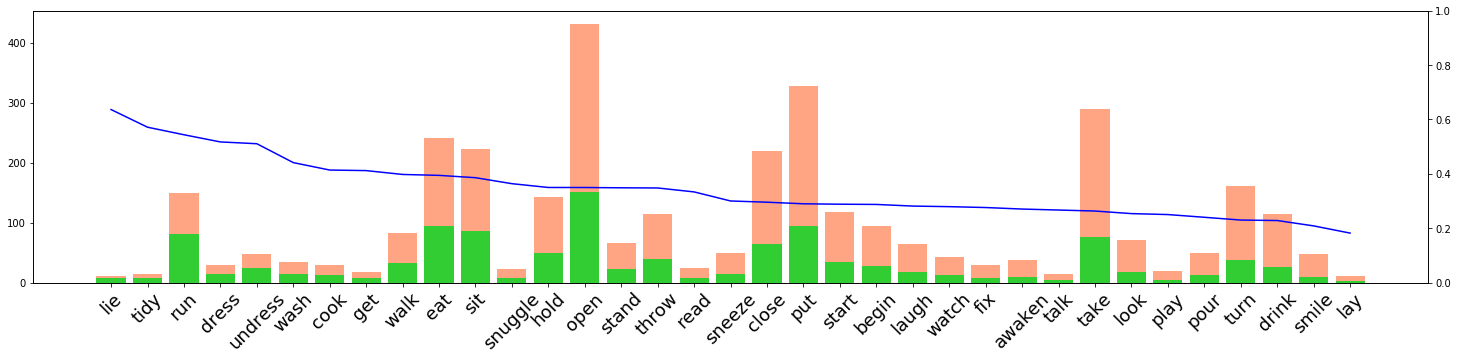

In [139]:
result_per_top_action = {}
for k, v in result_per_action.items():
    if len(v) > 10:
        result_per_top_action[k] = v

order = np.argsort([np.mean(v) for v in result_per_top_action.values()])[::-1]
keys = list(result_per_top_action.keys())
values = list(result_per_top_action.values())
keys = [keys[i] for i in order]
values = [values[i] for i in order]


n = len(keys)

fig, ax1 = plt.subplots(figsize=(25, 5))
_ = plt.xticks(np.arange(n), keys, rotation=45, fontsize=18)

ax1.bar(np.arange(n), [len(v) for v in values], color="coral", alpha=.7)
ax1.bar(np.arange(n), [sum(v) for v in values], color="limegreen", alpha=1)

ax2 = ax1.twinx()
ax2.plot(np.arange(n), [np.mean(v) for v in values], color="blue")
ax2.set_ylim(0, 1)

In [126]:
results = computer_eval(preds, gts, 0.5, recall_at)

In [129]:
res_arr = np.vstack([res for res in results.values()])
print(f"R@1 {res_arr[:, 0].mean():.2}")
print(f"R@5 {res_arr[:, 1].mean():.2}")
print(f"R@10 {res_arr[:, 2].mean():.2}")

R@1 0.33
R@5 0.75
R@10 0.9
